<a href="https://colab.research.google.com/github/neel-shel/Kalman-filter/blob/main/ADSP_Kalman_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMPORT LIBRARIES**

In [336]:
import pandas as pd
import numpy as np
import scipy
import sklearn
import matplotlib.pyplot as plt
import mpmath
import math
from tqdm import tqdm
from copy import deepcopy
import seaborn as sns

# **Parameters**

In [337]:
#DO NOT CHANGE THIS CELL
%matplotlib inline
# set seed
seed = 40
np.random.seed(seed)
pi=3.14159
epsilon=1e-3
delta_t=epsilon

In [338]:
# DO NOT CHANGE THIS CELL
total_epochs=10
w_ie=7.2921159e-6
R_e=6974e3
INS_out_freq=100

In [339]:
#chi squared function
def chi(x,df=1):
  '''chi takes in x & degree of freedom and returns chi squared distribution'''
  x=np.add(x,epsilon)
  x=x.astype(complex)
  chi=np.multiply(np.divide(0.5**(df/2),math.gamma(df/2)),np.multiply(np.divide(np.float_power(x,df/2),x),np.exp(np.multiply(-0.5,x))))
  return chi

In [340]:
def sqmat(x,y):
  return np.matmul(x,np.matmul(y,np.transpose(x)))

# **Kalman filter algorithm**

In [341]:
def kf(phi,x_prev,gamma,w_prev,h,v):
  '''Phi_k,k-1: State Transition matrix
     X_prev: Previous state matrix
     Gamma_k,k-1: Matrix of noise driving
     W_prev: noise vector of system
     H_k: Measurement matrix
     V_k: Measurement noise'''
  x_curr = np.add(np.matmul(phi,x_prev),np.matmul(gamma,w_prev))
  z=np.add(np.matmul(h,x_curr),v)
  return x_curr,z

In [342]:
def expected_val(x,pdf='chi'):
  if pdf == 'uniform':
    prob=np.divide(x,np.sum(x))
  elif pdf == 'gaussian':
    prob=np.random.normal(x)
  else:
    prob=chi(x)
  exp=np.multiply(x,prob)
  return exp

In [343]:
#sample test case
x=[3,6,5,7.89,0,12,2]
print(expected_val(x,'chi'))


[0.15407758+0.j 0.0486238 +0.j 0.07318099+0.j 0.02167266+0.j
 0.        +0.j 0.00342372+0.j 0.20739815+0.j]


In [344]:
def covariance(x,y):
  cov=expected_val(np.matmul(np.subtract(x,expected_val(x)),np.transpose(np.subtract(y,expected_val(y)))))
  return cov

In [345]:
def error_var(Phi,P_prev,Gamma_prev,Q_prev):
  return np.add(sqmat(Phi,P_prev),sqmat(Gamma_prev,Q_prev))

In [346]:
def kf_gain(P_currOld,H_curr,R_curr):
  if np.linalg.det(np.add(sqmat(H_curr,P_currOld),R_curr))!=0:
    temp=np.linalg.inv(np.add(sqmat(H_curr,P_currOld),R_curr))
    #print(temp)
    return np.matmul(P_currOld,np.matmul(np.transpose(H_curr),temp))
  else:
    H_curr=np.add(H_curr,10*epsilon*np.random.randn())
    P_currOld=np.add(P_currOld,10*epsilon*np.random.randn())
    R_curr=np.add(R_curr,10*epsilon*np.random.randn())
    temp=np.linalg.inv(np.add(sqmat(H_curr,P_currOld),R_curr))
    #print(temp)
    return np.matmul(P_currOld,np.matmul(np.transpose(H_curr),temp))

In [347]:
def state_est(X_pred_newOld,K_curr,Z_curr,H_curr):
  temp=np.subtract(Z_curr,np.matmul(H_curr,X_pred_newOld))
  temp=np.matmul(K_curr,temp)
  return np.add(X_pred_newOld,temp)

def state_est_error(K_curr,H_curr,P_currOld):
  return np.matmul(np.subtract(1,np.matmul(K_curr,H_curr)),P_currOld)

In [348]:
def kf_update(Phi,Gamma_prev,X_prev,X_pred_prev,P_prev,Q_prev,R_curr,H_curr,Z_curr):
  '''Phi: (15,15)
  Gamma: (15,6)
  X: (15,1)
  P: (15,15)
  Q: (6,6)
  H: (3,15)
  R: (3,3)
  W: (6,1)
  X=Phi.X+Gamma.W
  '''

  X_pred_newOld=np.transpose([np.matmul(Phi,X_pred_prev)])
  P_currOld=error_var(Phi,P_prev,Gamma_prev,Q_prev)
  K_curr=kf_gain(P_currOld,H_curr,R_curr)
  X_pred_new=state_est(X_pred_newOld,K_curr,Z_curr,H_curr)
  P_curr=state_est_error(K_curr,H_curr,P_currOld)

  return K_curr,X_pred_new,P_curr

In [349]:
def innovation_covariance(r_curr,r_pred_curr,R_curr,k):
  return np.add(np.dot(1/(k+1),np.matmul(np.subtract(r_curr,r_pred_curr),np.transpose(np.subtract(r_curr,r_pred_curr)))),R_curr)

In [371]:
def skew_symm(x):
  '''x is (3,1) coloumn vector'''
  if x.shape!=(3,):
    raise Exception('Please enter a (3,1) coloumn vector')
  return [[0,-x[2],x[1]],[x[2],0,-x[0]],[-x[1],x[0],0]]

In [351]:
def navig_frame(L,Lambda):
  return [[-1*math.sin(Lambda),-1*math.sin(L)*math.cos(Lambda),math.cos(L)*math.cos(Lambda)],[math.cos(Lambda),-1*math.sin(L)*math.sin(Lambda),math.cos(L)*math.sin(Lambda)],[0,math.cos(L),math.sin(L)]]

In [352]:
def rover_body_frame(theta,phi,psi):
  '''theta:
  phi:
  psi:'''
  Rb_to_n=[[math.cos(theta)*math.cos(phi)-math.sin(theta)*math.sin(phi)*math.sin(psi),-math.cos(phi)*math.sin(psi),math.sin(theta)*math.cos(psi)+math.cos(theta)*math.sin(phi)*math.sin(psi)],[math.cos(theta)*math.sin(psi)+math.sin(theta)*math.sin(phi)*math.sin(psi),math.cos(phi)*math.cos(psi),math.sin(theta)*math.sin(phi)-math.cos(theta)*math.sin(phi)*math.cos(psi)],[-math.sin(theta)*math.cos(phi),math.sin(phi),math.cos(theta)*math.cos(phi)]]
  return np.array(Rb_to_n)

In [353]:
def rel_motion_err(R_error,R_bn_curr,R_bn_prev,r_curr,r_prev,delta_r_curr):
  R_ins=np.matmul(R_error,np.matmul(np.transpose(R_bn_curr),R_bn_prev))
  T_ins=np.add(np.subtract(r_curr,r_prev),delta_r_curr)
  return R_ins,T_ins

In [354]:
def f1_n(w_ie,w_en,V_e,V_n,V_u,g_n):
  V=np.transpose([V_e,V_n,V_u])
  f_n=np.add(V,np.subtract(skew_symm(np.add(np.dot(2,w_ie),w_en)),g_n))
  return f_n

In [355]:
# Basic IMU equations
def INS_model(delta_Phi_e,delta_Phi_n,delta_Phi_u,Phi_e,Phi_n,Phi_u,V_e,V_n,V_u,L,Lambda,h,deltaL,deltaLambda,deltaH,Epsilon_x,Epsilon_y,Epsilon_z,Del_x,Del_y,Del_z,g_n):
  '''[Phi_e,Phi_n,Phi_u] is attitude angle
  [delta_Phi_e,delta_Phi_n,delta_Phi_u]: error angle
  [V_e,V_n,V_u]: Velocity
  [deltaV_e,deltaV_n,deltaV_u] is velocity error
  [deltaL,deltaLambda,deltaH]: Position error
  [Epsilon_x,Epsilon_y,Epsilon_z]: Gyroscopic drift
  [Del_x,Del_y,Del_z]: accelerometer bias
  [L,Lamda,h]: latitude, longitude, height'''

  w_ie_matrix=np.transpose([0,w_ie*math.cos(L),w_ie*math.sin(L)])
  w_en=np.dot(1/R_e,np.transpose([-1*V_n,V_e,V_e*math.tan(L)]))
  V_ins=np.transpose([V_e,V_n,V_u])
  r_ins=np.transpose([L,Lambda,h])


  w_in=np.add(w_ie_matrix,w_en)
  w_ib=np.dot(1/T,np.transpose([Phi_e,Phi_n,Phi_u]))
  w_nb=np.subtract(w_ib,np.matmul(navig_frame(L,Lambda),np.add(w_en,w_ie_matrix)))
  W_nb=np.array(skew_symm(w_nb))


  R_dot_nb=np.matmul(-W_nb,np.transpose(rover_body_frame(Phi_e,Phi_n,Phi_u)))
  v_dot_ins=np.add(np.subtract(rover_body_frame(Phi_e,Phi_n,Phi_u),np.matmul(skew_symm(np.add(np.dot(2,w_ie_matrix),w_en)),V_ins)),g_n)
  C=np.array([[0,1/R_e,0],[1/(R_e*math.cos(L)),0,0],[0,0,0]])
  r_dot_ins=np.matmul(C,V_ins)
  r_ins_k=np.dot(R_e,np.matmul(navig_frame(L,Lambda),np.transpose([0,0,1]))) # r_ins(k)


  def INS_state_model(f_n):
    delta_r=np.transpose([deltaL,deltaLambda,deltaH])
    delta_v=np.transpose([deltaV_e,deltaV_n,deltaV_u])
    delta_w_ie=np.transpose([0,-w_ie*math.sin(L)*deltaL,w_ie*math.cos(L)*deltaL])
    del_w_en=np.transpose([-deltaV_n/R_e,deltaV_e/R_e,deltaV_e/R_e*math.tan(L)+deltaV_e/R_e/(math.cos(L))**2*deltaL])
    delta_w_in=np.add(delta_w_ie,del_w_en)

    Phi_dot=np.add(np.matmul(skew_symm(np.transpose([Phi_e,Phi_n,Phi_u])),delta_w_in),np.subtract(delta_w_in,np.transpose([Epsilon_x,Epsilon_y,Epsilon_z])))
    delta_v_dot=np.add(np.dot(-1,np.add(np.add(np.matmul(skew_symm(np.transpose([Phi_e,Phi_n,Phi_u])),f_n),np.matmul(skew_symm(np.add(np.transpose(np.dot(2,delta_w_ie)),del_w_en)),V_ins)),np.matmul(skew_symm(np.add(np.transpose(np.dot(2,delta_w_ie)),del_w_en)),delta_v))),[Del_x,Del_y,Del_z])
    D=np.array([[V_e/R_e/math.cos(L)*math.tan(L),0,0],[0,0,0],[0,0,0]])
    delta_r_dot=np.add(np.matmul(C,delta_v),np.matmul(D,delta_r))
    return Phi_dot,delta_v_dot,delta_r_dot
  f_n=f1_n(w_ie_matrix,w_en,V_e,V_n,V_u,g_n)
  Phi_dot,delta_v_dot,delta_r_dot=INS_state_model(f_n)
  Phi_new=np.add(np.transpose([Phi_e,Phi_n,Phi_u]),np.multiply(np.transpose([delta_Phi_e,delta_Phi_n,delta_Phi_u]),Phi_dot))

  def INS_meas_model(r_curr,R_bn_ins_k,R_dot_nb):
    # Measurement model
    R_prev=rover_body_frame(Phi_e,Phi_n,Phi_u)
    R_curr=np.add(R_prev,np.dot(epsilon,np.transpose(R_dot_nb)))
    R_err=np.matmul(np.transpose(R_bn_ins_k),np.matmul(rover_body_frame(Phi_e,Phi_n,Phi_u),r_curr))
    delta_r_curr=np.dot(delta_t,delta_r_dot)
    r_prev=np.subtract(r_curr,delta_r_curr)

    R_ins,T_ins=rel_motion_err(R_err,R_curr,R_prev,r_curr,r_prev,delta_r_curr)

    return R_ins,T_ins,R_err
  R_ins_prev=navig_frame(L,Lambda)
  R_ins,T_ins,R_err=INS_meas_model(r_ins_k,R_ins_prev,R_dot_nb)
  R_ins_prev=R_ins
  return r_ins_k,Phi_new,R_ins,T_ins,R_err





## **State Parameters**

In [356]:
def state_transition_matrix(Phi_e,Phi_n,Phi_u,L,Lambda,h,V_e,V_n,V_u,w_ie,R_m=R_e,R_n=R_e):
  M_aa=np.array([[0,w_ie*math.sin(L)+V_e*math.tan(L)/(R_n+h),-(w_ie*math.cos(L)+V_e/(R_n+h))],
                 [-(w_ie*math.sin(L)+V_e*math.tan(L)/(R_n+h)),0,-V_n/(R_m+h)],
                 [w_ie*math.cos(L)+V_e/(R_n+h),V_n/(R_m+h),0]])
  M_av=np.array([[0,1/(R_m+h),0],
                 [1/(R_n+h),0,-V_n/(R_m+h)],
                 [math.tan(L)/(R_n+h),0,0]])
  M_ap=np.array([[0,0,0],
                 [-w_ie*math.sin(L),0,0],
                 [w_ie*math.cos(L)+V_e/(math.cos(L))**2/(R_n+h),0,0]])
  M_va=np.array([[0,-f_u,f_n],
                 [f_u,0,f_e],
                 [-f_n,f_e,0]])
  M_vv=np.array([[V_n*math.tan(L)/(R_n+h)-V_u/(R_n+h),2*w_ie*math.sin(L)+V_e*math.tan(L)/(R_n+h),2*w_ie*math.cos(L)+V_e/(R_n+h)],
                 [-2*w_ie*math.sin(L)+V_e*math.tan(L)/(R_n+h),-V_u/(R_m+h),-V_n/(R_m+h)],
                 [2*(w_ie*math.cos(L)+V_e/(R_n+h)),2*V_n/(R_m+h),0]])
  M_vp=np.array([[2*w_ie*math.cos(L)*V_n+V_n*V_e/math.pow(math.cos(L),2)/(R_n+h),2*w_ie*math.sin(L)+V_e*math.tan(L)/(R_n+h),2*w_ie*math.cos(L)+V_e/(R_n+h)],
                 [-(2*w_ie*math.cos(L)*V_e+V_e*V_e/math.pow(math.cos(L),2)/(R_n+h)),0,0],
                 [-2*w_ie*math.sin(L)*V_e,0,0]])
  M_pv=np.array([[0,-1/(R_m+h),0],
                 [1/(R_n+h)/math.cos(L),0,0],
                 [0,0,1]])
  M_pp=np.array([[0,0,0],
                 [V_e*math.tan(L)/math.cos(L)/(R_n+h),0,0],
                 [0,0,1]])
  C_bn=rover_body_frame(Phi_e,Phi_n,Phi_u)
  F_t=np.array([[M_aa[0,0],M_aa[0,1],M_aa[0,2],M_av[0,0],M_av[0,1],M_av[0,2],M_ap[0,0],M_ap[0,1],M_ap[0,2],C_bn[0,0],C_bn[0,1],C_bn[0,2],0,0,0],
                [M_aa[1,0],M_aa[1,1],M_aa[1,2],M_av[1,0],M_av[1,1],M_av[1,2],M_ap[1,0],M_ap[1,1],M_ap[1,2],C_bn[1,0],C_bn[1,1],C_bn[1,2],0,0,0],
                [M_aa[2,0],M_aa[2,1],M_aa[2,2],M_av[2,0],M_av[2,1],M_av[2,2],M_ap[2,0],M_ap[2,1],M_ap[2,2],C_bn[2,0],C_bn[2,1],C_bn[2,2],0,0,0],
                [M_va[0,0],M_va[0,1],M_va[0,2],M_vv[0,0],M_vv[0,1],M_vv[0,2],M_vp[0,0],M_vp[0,1],M_vp[0,2],0,0,0,C_bn[0,0],C_bn[0,1],C_bn[0,2]],
                [M_va[1,0],M_va[1,1],M_va[1,2],M_vv[1,0],M_vv[1,1],M_vv[1,2],M_vp[1,0],M_vp[1,1],M_vp[1,2],0,0,0,C_bn[1,0],C_bn[1,1],C_bn[1,2]],
                [M_va[2,0],M_va[2,1],M_va[2,2],M_vv[2,0],M_vv[2,1],M_vv[2,2],M_vp[2,0],M_vp[2,1],M_vp[2,2],0,0,0,C_bn[2,0],C_bn[2,1],C_bn[2,2]],
                [0,0,0,M_pv[0,0],M_pv[0,1],M_pv[0,2],M_pp[0,0],M_pp[0,1],M_pp[0,2],0,0,0,0,0,0,],
                [0,0,0,M_pv[1,0],M_pv[1,1],M_pv[1,2],M_pp[1,0],M_pp[1,1],M_pp[1,2],0,0,0,0,0,0,],
                [0,0,0,M_pv[2,0],M_pv[2,1],M_pv[2,2],M_pp[2,0],M_pp[2,1],M_pp[2,2],0,0,0,0,0,0,],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]])
  return F_t

In [357]:
def noise_navig_coord_sys(Epsilon_x,Epsilon_y,Epsilon_z,Del_x,Del_y,Del_z):
  w_gx=chi(Epsilon_x)
  w_gy=chi(Epsilon_y)
  w_gz=chi(Epsilon_z)
  w_ax=chi(Del_x)
  w_ay=chi(Del_y)
  w_az=chi(Del_z)
  return np.transpose(np.array([w_gx,w_gy,w_gz,w_ax,w_ay,w_az]))

In [358]:
def noise_driving(Phi_e,Phi_n,Phi_u):
  C_bn=rover_body_frame(Phi_e,Phi_n,Phi_u)
  G_t=np.array([[C_bn[0,0],C_bn[0,1],C_bn[0,2],0,0,0],
                [C_bn[1,0],C_bn[1,1],C_bn[1,2],0,0,0],
                [C_bn[2,0],C_bn[2,1],C_bn[2,2],0,0,0],
                [0,0,0,C_bn[0,0],C_bn[0,1],C_bn[0,2]],
                [0,0,0,C_bn[1,0],C_bn[1,1],C_bn[1,2]],
                [0,0,0,C_bn[2,0],C_bn[2,1],C_bn[2,2]],
                [0,0,0,0,0,0],
                [0,0,0,0,0,0],
                [0,0,0,0,0,0],
                [0,0,0,0,0,0],
                [0,0,0,0,0,0],
                [0,0,0,0,0,0],
                [0,0,0,0,0,0],
                [0,0,0,0,0,0],
                [0,0,0,0,0,0]])
  return G_t

##**Riccati inequality**

In [359]:
def gamma(x_curr,H_curr,L_curr=np.identity(15)):
  P_curr=covariance(x_curr,x_curr)
  gamma=np.sqrt(np.matmul(np.add(np.linalg.inv(P_curr),np.matmul(np.transpose(H_curr),H_curr)),np.linalg.inv(np.matmul(np.transpose(L_curr),L_curr))))-epsilon
  return gamma

## **H infinity filter**

In [360]:
def Rinv_ek(P_currOld,H_curr,L_curr,gamma):
  return np.add([[np.identity(15),0],[0,np.dot(-gamma**2,np.identity(15))]],sqmat([H_curr,L_curr],P_currOld))

In [361]:
def H_inf_filter(Phi,P_currOld,H_curr,L_curr):
  Rinv_=Rinv_ek(P_currOld,H_curr,L_curr,gamma)
  P_currCurr=np.subtract(P_currOld,sqmat(Phi,np.matmul(P_currOld,np.matmul(P_currOld,np.matmul([np.transpose(H_curr),np.transpose(L_curr)],np.matmul(Rinv_,np.matmul(np.transpose([H_curr,L_curr]),P_currOld)))))))
  return P_currCurr

In [362]:
def fading_filter(Phi,gamma,x_prev,w_curr,H_curr,v_curr,P_prev,n=15):
  L_curr=np.identity(n)
  R_curr=covariance(v_curr,v_curr)
  Q_curr=covariance(w_curr,w_curr)
  M_curr=sqmat(H_curr,sqmat(Phi,P_prev))
  P_Vk=expected_val(np.matmul(v_curr,np.transpose(v_curr)),'gaussian')
  N_curr=np.subtract(P_Vk,np.add(sqmat(H_curr,Q_curr),R_curr))
  S_curr1=max(1,1/n*np.trace(np.matmul(N_curr,np.linalg.inv(M_curr))))
  S_curr2=max(1,np.trace(N_curr)/np.trace(M_curr))
  S_curr=0.5*(S_curr1+S_curr2)
  assert S_curr>=1,print('Fading factor must be more than 1')

  x_curr,z_curr=kf(Phi,x_prev,gamma,w_curr,H_curr,v_curr)
  x_currOld=np.matmul(Phi,x_prev)
  P_currOld=np.add(np.matmul(S_curr,sqmat(Phi,P_prev)),Q_curr)
  K_curr=kf_gain(P_currOld,H_curr,R_curr)
  x_currCurr=np.add(x_currOld,np.matmul(K_curr,np.subtract(z_curr,np.matmul(H_curr,x_currOld))))
  P_currCurr=H_inf_filter(Phi,P_currOld,H_curr,L_curr)
  return np.subtract(P_currCurr,P_currOld)

# **Training**

In [363]:
H_t=np.array([[0,0,0,0,0,0,1,0,0,0,0,0,0,0,0],
     [0,0,0,0,0,0,0,1,0,0,0,0,0,0,0],
     [0,0,0,0,0,0,0,0,1,0,0,0,0,0,0]])
def model(phi_e,phi_n,phi_u,delta_Phi_e,delta_Phi_n,delta_Phi_u,V_e,V_n,V_u,deltaV_e,deltaV_n,deltaV_u,deltaL,deltaLambda,deltaH,Epsilon_x,Epsilon_y,Epsilon_z,Del_x,Del_y,Del_z,L,Lambda,h,total_epochs):
  for k in range(0,total_epochs):
    r_ins,phi_new,R_ins,T_ins,R_err=INS_model(delta_Phi_e,delta_Phi_n,delta_Phi_u,phi_e,phi_n,phi_u,V_e,V_n,V_u,L,Lambda,h,deltaL,deltaLambda,deltaH,Epsilon_x,Epsilon_y,Epsilon_z,Del_x,Del_y,Del_z,g_n)
    P_t=np.random.randn(15,15)
    X_t=np.transpose([phi_e,phi_n,phi_u,deltaV_e,deltaV_n,deltaV_u,deltaL,deltaLambda,deltaH,Epsilon_x,Epsilon_y,Epsilon_z,Del_x,Del_y,Del_z])
    F_t=state_transition_matrix(phi_e,phi_n,phi_u,L,Lambda,h,V_e,V_n,V_u,w_ie)
    G_t=noise_driving(phi_e,phi_n,phi_u)
    W_t=noise_navig_coord_sys(Epsilon_x,Epsilon_y,Epsilon_z,Del_x,Del_y,Del_z)
    X_pred_t=np.add(np.matmul(F_t,X_t),np.matmul(G_t,W_t))
    V_t=np.transpose([eta_L,eta_Lambda,eta_h])
    Z_t=np.transpose(np.add(np.matmul(H_t,X_t),V_t))
    Q_t=covariance(np.transpose(np.array([W_t])),np.transpose(np.array([W_t])))
    R_t=covariance(np.transpose(V_t),np.transpose(V_t))
    K_t,X_pred_t,P_t=kf_update(F_t,np.random.randn(15,6),X_t,X_pred_t,P_t,Q_t,R_t,H_t,Z_t)
    phi_e=phi_new[0]
    phi_n=phi_new[1]
    phi_u=phi_new[2]
    delta_r_gnss=np.random.normal(size=(3,))
    Z_t=np.subtract(T_ins,delta_r_gnss)
    Z_t.reshape((3,1))
    V_t=np.subtract(Z_t,np.matmul(H_t,X_t))
    X_t=X_pred_t
  return K_t,Z_t,X_t

# **Sanity check**

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


(100, 15, 3)


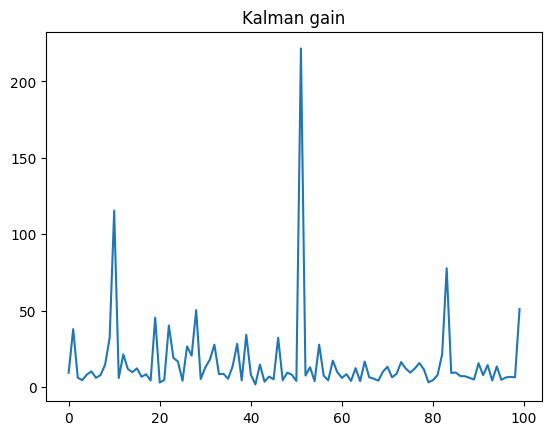

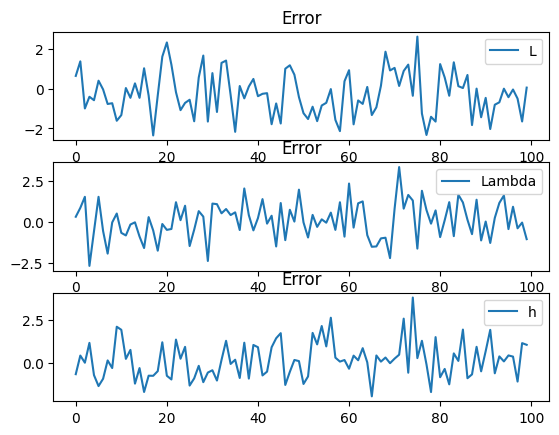

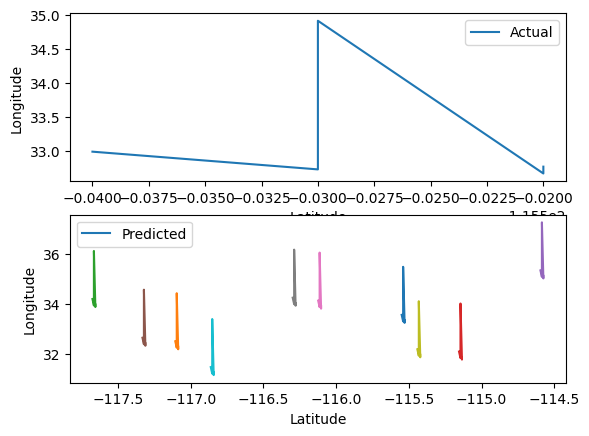

In [370]:
X_train=pd.read_csv('/content/sample_data/california_housing_train.csv')
L_list=X_train[['longitude']]
Lambda_list=X_train[['latitude']]
g_n=-9.81
#print(L_list.shape)
#print(Lambda_list.shape)
INS_out_freq=100
T=1/INS_out_freq
L_list=np.array(L_list)
Lambda_list=np.array(Lambda_list)
K=[]
Z=[]
X=[]
idx=np.random.randint(10,90)
for i in range(idx,idx+100):
  eta_L=np.random.randn()
  eta_Lambda=np.random.randn()
  eta_h=np.random.randn()
  L=L_list[i]
  Lambda=Lambda_list[i]
  h=eta_h
  f_u=400e-6*g_n*np.random.randn()
  f_n=np.random.randn()
  f_e=np.random.randn()
  #gyro bias
  Epsilon_x=5/3600*T*np.random.randn()
  Epsilon_y=5/3600*T*np.random.randn()
  Epsilon_z=5/3600*T*np.random.randn()
  #position wrt earth
  phi_e=5/3600
  phi_n=5/3600
  phi_u=5/3600
  #gyro angle random walk
  delta_Phi_e=0.5/60*T
  delta_Phi_n=0.5/60*T
  delta_Phi_u=0.5/60*T
  #accelerometer bias
  Del_x=400*0.01*np.random.randn()
  Del_y=400*0.01*np.random.randn()
  Del_z=400*0.01*np.random.randn()
  #velocity
  V_e=np.random.randn()
  V_n=np.random.randn()
  V_u=np.random.randn()
  #vel error
  deltaV_e=0.1*np.random.randn()
  deltaV_n=0.1*np.random.randn()
  deltaV_u=0.1*np.random.randn()
  #gps error
  deltaL=np.random.randn()
  deltaLambda=np.random.randn()
  deltaH=np.random.randn()

  X_t=np.transpose([phi_e,phi_n,phi_u,deltaV_e,deltaV_n,deltaV_u,deltaL,deltaLambda,deltaH,Epsilon_x,Epsilon_y,Epsilon_z,Del_x,Del_y,Del_z])
  K_t,Z_t,X_t = model(phi_e,phi_n,phi_u,delta_Phi_e,delta_Phi_n,delta_Phi_u,V_e,V_n,V_u,deltaV_e,deltaV_n,deltaV_u,deltaL,deltaLambda,deltaH,Epsilon_x,Epsilon_y,Epsilon_z,Del_x,Del_y,Del_z,L,Lambda,h,total_epochs)
  K.append(np.linalg.norm(K_t))
  Z.append(Z_t)
  X.append(X_t)
K_=np.array(K)
Z_=np.array(Z)
X_=np.array(X)
print(X_.shape)
plt.figure(1)
plt.plot(range(100),K_)
plt.title('Kalman gain')
plt.figure(2)
plt.subplot(311)
plt.plot(range(100),Z_[:,0])
plt.legend(['L'])
plt.title('Error')
plt.subplot(312)
plt.plot(range(100),Z_[:,1])
plt.legend(['Lambda'])
plt.title('Error')
plt.subplot(313)
plt.plot(range(100),Z_[:,2])
plt.legend(['h'])
plt.title('Error')
plt.figure(3)
plt.subplot(211)
plt.plot(L_list[idx:idx+10],Lambda_list[idx:idx+10])
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend(['Actual'])
plt.subplot(212)
plt.plot(L_list[idx:idx+10]+Z_[idx:idx+10,0],Lambda_list[idx:idx+10]+Z_[idx:idx+10,1])
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend(['Predicted'])

In [372]:
print(np.max(np.abs(K_)))
print(np.max(np.abs(Z_)))

221.55550907055934
3.7822925671112215


# **Adaptive Kalman filter proposed in the paper**

In [366]:
def prop_update(Phi,Gamma_prev,P_prev,X_prev,X_pred_prev,Q_curr,R_curr,V_curr,H,H_curr,Z_curr,W_prev,k,N=100):
  delta_x=T*epsilon #small interval
  Q_prev=covariance(np.transpose(np.array([W_prev])),np.transpose(np.array([W_prev])))

  R_pred1=[] # dummy var
  R_pred2=[] # dummy var
  X_pred_newOld=np.transpose([np.matmul(Phi,X_pred_prev)])
  P_currOld=error_var(Phi,P_prev,Gamma_prev,Q_prev)

  #constructing chi squared test using innovation series
  r_curr=np.subtract(Z_curr,np.matmul(H_curr,X_pred_newOld))
  T_curr=np.matmul(np.transpose(r_curr),np.matmul(sqmat(H,P_currOld),r_curr))
  C_curr=np.add(sqmat(H_curr,P_currOld),R_curr)

  # traditional adaptive filter
  sum=np.zeros(shape=np.shape(np.matmul(r_curr,np.transpose(r_curr))))
  for i in enumerate(range(0,k)):
    if k!=1:
      sum=np.dot(1/(k-1),np.add(sum,np.matmul(r_curr,np.transpose(r_curr))))
  C_pred_curr=sum
  R_pred_trad=np.subtract(C_pred_curr,np.matmul(H,np.matmul(P_currOld,np.transpose(H))))
  sum=np.zeros(shape=np.shape(delta_x))
  K_curr=np.matmul(P_currOld,np.matmul(np.transpose(H_curr),np.linalg.inv(np.add(sqmat(H_curr,P_currOld),R_curr))))
  P_curr=np.matmul(np.subtract(1,np.matmul(K_curr,H_curr)),P_currOld)
  for i in enumerate(range(0,k)):
    Q_pred_curr=np.add(np.dot(1/N,np.add(sum,np.transpose(delta_x))),np.add(P_curr,sqmat(Phi,P_prev)))

  sum=np.zeros(shape=r_curr.shape)
  for i in enumerate(range(0,k)):
    sum=np.add(r_curr,sum)
  r_pred_curr=np.dot(1/(k+1),sum)
  R_pred_curr=np.subtract(C_pred_curr,sqmat(H,P_currOld))


  R_pred_curr_innov=innovation_covariance(r_curr,r_pred_curr,R_curr,k)


  #propsed update sol for adaptive kalman filter
  K_prop,X_pred_new,P_prop=kf_update(Phi,Gamma_prev,X_prev,X_pred_prev,P_prev,Q_prev,np.subtract(R_pred_curr_innov,R_pred_curr),H_curr,Z_curr)


  return K_prop,X_pred_new,P_prop



In [367]:
H_t=np.array([[0,0,0,0,0,0,1,0,0,0,0,0,0,0,0],
     [0,0,0,0,0,0,0,1,0,0,0,0,0,0,0],
     [0,0,0,0,0,0,0,0,1,0,0,0,0,0,0]])
def model1(phi_e,phi_n,phi_u,delta_Phi_e,delta_Phi_n,delta_Phi_u,V_e,V_n,V_u,deltaV_e,deltaV_n,deltaV_u,deltaL,deltaLambda,deltaH,Epsilon_x,Epsilon_y,Epsilon_z,Del_x,Del_y,Del_z,L,Lambda,h,total_epochs):
  for k in range(0,total_epochs):
    r_ins,phi_new,R_ins,T_ins,R_err=INS_model(delta_Phi_e,delta_Phi_n,delta_Phi_u,phi_e,phi_n,phi_u,V_e,V_n,V_u,L,Lambda,h,deltaL,deltaLambda,deltaH,Epsilon_x,Epsilon_y,Epsilon_z,Del_x,Del_y,Del_z,g_n)
    P_t=np.random.randn(15,15)
    X_t=np.transpose([phi_e,phi_n,phi_u,deltaV_e,deltaV_n,deltaV_u,deltaL,deltaLambda,deltaH,Epsilon_x,Epsilon_y,Epsilon_z,Del_x,Del_y,Del_z])
    F_t=state_transition_matrix(phi_e,phi_n,phi_u,L,Lambda,h,V_e,V_n,V_u,w_ie)
    G_t=noise_driving(phi_e,phi_n,phi_u)
    W_t=noise_navig_coord_sys(Epsilon_x,Epsilon_y,Epsilon_z,Del_x,Del_y,Del_z)
    X_pred_t=np.add(np.matmul(F_t,X_t),np.matmul(G_t,W_t))
    V_t=np.transpose([eta_L,eta_Lambda,eta_h])
    Z_t=np.transpose(np.add(np.matmul(H_t,X_t),V_t))
    Q_t=covariance(np.transpose(np.array([W_t])),np.transpose(np.array([W_t])))
    R_t=covariance(np.transpose(V_t),np.transpose(V_t))
    K_t,X_pred_t,P_t=prop_update(F_t,np.random.randn(15,6),X_t,X_pred_t,P_t,Q_t,R_t,H_t,Z_t)
    phi_e=phi_new[0]
    phi_n=phi_new[1]
    phi_u=phi_new[2]
    delta_r_gnss=np.random.normal(size=(3,))
    Z_t=np.subtract(T_ins,delta_r_gnss)
    Z_t.reshape((3,1))
    V_t=np.subtract(Z_t,np.matmul(H_t,X_t))
  return K_t,Z_t

In [368]:
for i in range(100):
  eta_L=np.random.randn()
  eta_Lambda=np.random.randn()
  eta_h=np.random.randn()
  L=L_list[i]
  Lambda=Lambda_list[i]
  h=eta_h
  f_u=400e-6*g_n*np.random.randn()
  f_n=0
  f_e=0
  #gyro bias
  Epsilon_x=5/3600*T*np.random.randn()
  Epsilon_y=5/3600*T*np.random.randn()
  Epsilon_z=5/3600*T*np.random.randn()
  #position wrt earth
  phi_e=5/3600
  phi_n=5/3600
  phi_u=5/3600
  #gyro angle random walk
  delta_Phi_e=0.5/60*T
  delta_Phi_n=0.5/60*T
  delta_Phi_u=0.5/60*T
  #accelerometer bias
  Del_x=400*0.01*np.random.randn()
  Del_y=400*0.01*np.random.randn()
  Del_z=400*0.01*np.random.randn()
  #velocity
  V_e=np.random.randn()
  V_n=np.random.randn()
  V_u=np.random.randn()
  #vel error
  deltaV_e=0.1*np.random.randn()
  deltaV_n=0.1*np.random.randn()
  deltaV_u=0.1*np.random.randn()
  #gps error
  deltaL=np.random.randn()
  deltaLambda=np.random.randn()
  deltaH=np.random.randn()

  K_t,Z_t=model(phi_e,phi_n,phi_u,delta_Phi_e,delta_Phi_n,delta_Phi_u,V_e,V_n,V_u,deltaV_e,deltaV_n,deltaV_u,deltaL,deltaLambda,deltaH,Epsilon_x,Epsilon_y,Epsilon_z,Del_x,Del_y,Del_z,L,Lambda,h,total_epochs)
  K.append(np.linalg.norm(K_t))
  Z.append(Z_t)
  K_=np.array(K)
  Z_=np.array(Z)
  plt.figure(1)
  plt.plot(range(100),K_)
  plt.title('Kalman gain')
  plt.figure(2)
  plt.subplot(311)
  plt.plot(range(100),Z_[:,0])
  plt.legend(['L'])
  plt.title('Error')
  plt.subplot(312)
  plt.plot(range(100),Z_[:,1])
  plt.legend(['Lambda'])
  plt.title('Error')
  plt.subplot(313)
  plt.plot(range(100),Z_[:,2])
  plt.legend(['h'])
  plt.title('Error')

ValueError: ignored